# Qarameterized circuits: Quantum parameters for QML
**Evan Peters**, University of Waterloo, Institute for Quantum Computing  
**Prasanth Shyamsundar**, Fermi National Accelerator Laboratory, Fermilab Quantum Institute

GitHub epository: [https://github.com/peterse/groveropt](https://github.com/peterse/groveropt)

### Preface

_So you want to train your quantum circuit, but you're tired of optimizing everything **classically**...?_

Variational quantum circuits are the foundation of many near term quantum algorithms, from quantum chemistry to quantum machine learning. In most of these applications, the parameters of the circuits are optimized using a **classical** optimizer.

In this project, we propose **Qarameterized (Quantum-parameterized) circuits** for the optimization of variational circuits.

### 1. What is a Qarameterized Circuit?

A Qarameterized circuit is a variational circuit that is parameterized by control quantum registers (possibly in addition to classical free parameters). The state of the control registers controls the action of the circuit. Quantum parameterization has been proposed previously, for example in [(Verdon, 2018)](https://arxiv.org/abs/1806.09729) and [(Shyamsundar, 2021)](https://arxiv.org/abs/2102.04975).

In this project, we elevate the rotation angles used in variational circuits into being quantum parameters.
* The originally classically-parameterized rotation gates are replaced by controlled rotation gates, with the quantum parameters serving as controls.
* The computational basis states of quantum parameters correspond to discrete values of the rotation angles in the range $[0, 2\pi)$.
* Setting the state of the quantum parameters to one of the computational basis states simply mimics the corresponding classically-parameterized circuit.

<img src="img/lifting_diagram/lifting_diagram.png" width=700 height=200 />

As an example, here is a classically parameterized circuit, with two trainable parameters:  
<img src="img/cparam_circuit.png" width=350 />  
And here is the corresponding qarameterized circuit, which uses a 5-qubit register for each of the two quantum parameters:  
<img src="img/qparam_circuit.png" width=900 />

### 2. Why use a Qarameterized Circuit? **Superposition!**

The main advantage of using quantum parameters is that they can exist in a superposition of the computational basis states. This opens up the possibility of finding good/optimal states for the quantum parameters in a manifestly quantum manner.

### Oracles to evaluate the states of the quantum parameters

In order to optimize the values of parameters, classical or quantum, we need a way to evaluate the parameter values (or states). In order to leverage the superposition aspect of Qarameterized circuits discussed above, we need to _coherently_ evaluate the states of the quantum parameters.

[(Shyamsundar, 2021)](https://arxiv.org/abs/2102.04975) provides prescriptions to construct non-boolean oracles, which evaluate the basis states of the quantum parameters by applying a state-dependent phase on them.

In this project, the goal of the optimization is to find train the variational circuit to produce a given target state, namely $|0\rangle$. This is inline with the objective function used in [https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html](https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html). We created an oracle which evaluates the quantum parameters based on the following score function:
$$\mathrm{score} = \Big|\big\langle\psi(\theta_\mathrm{quant})\big|0\big\rangle\Big|^2$$

> Some additional details about the oracle used in this project can be found in `more_detailed.ipynb` in the [GitHub repository](https://github.com/peterse/groveropt).

### 3. Training Qarameterized circuits using amplitude amplification

[(Shyamsundar, 2021)](https://arxiv.org/abs/2102.04975) introduces the non-boolean amplitude amplification algorithm, which can preferentially amplify the states of the quantum parameters based on an objective function. Here we use the algorithm to amplify the good states of the control registers.

### 4. Measuring the quantum parameter

Measuring the state of the control register after the amplification process will yield good states for the quantum parameters. This completes the manifestly-quantum, gradient-free training of our Qarameterized circuits.

#### The four key ideas discussed above are captured by the following animation:
<img src="img/lifting_animation/lifting_animation.png" width=2000 height=913 />

## Demonstration

We begin by creating a random variational circuit with two trainable parameters.

In [1]:
from src.qarameterize import RandomCircuit
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 16})

NUM_QUBITS = 2
PRECISION = 5
SEED = 1

rc = RandomCircuit(num_qubits=NUM_QUBITS, precision_qparams=PRECISION, seed=SEED)

### Classical-parameters version of the circuit:

<img src="img/cparam_circuit.png" width=350 />

Since this circuit has only two trainable parameters, it is easy to visualize the score landscape for different values of the parameters.

#### Simulating the classical-parameters version

In [2]:
max_param = 2*np.pi
binwidth = 2*np.pi/2**PRECISION

# Bottom-left corner is the representative value for each cell
param_0_binedges = np.linspace(0, 2*np.pi, num=2**PRECISION+1, endpoint=True)
param_1_binedges = np.linspace(0, 2*np.pi, num=2**PRECISION+1, endpoint=True)
param_0_binedges, param_1_binedges = np.meshgrid(param_0_binedges, param_1_binedges)

param_0_vals_flat = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
param_1_vals_flat = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
param_0_vals, param_1_vals = np.meshgrid(param_0_vals_flat, param_1_vals_flat)

# Evaluate the cost landscape for the random circuit
score_landscape = np.ones_like(param_0_vals)
for idx in np.ndindex(param_0_vals.shape):
    score_landscape[idx] = rc.target_prob([param_0_vals[idx], param_1_vals[idx]])

#### Plotting the score landscape

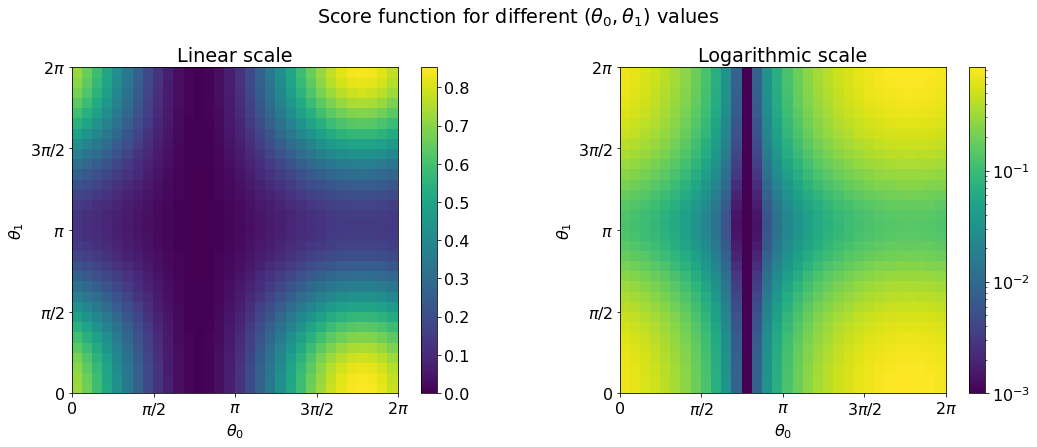

In [3]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(18, 6))

_ = ax0.pcolormesh(param_0_binedges, param_1_binedges, score_landscape)
plt.colorbar(_, ax=ax0)
ax0.set_aspect('equal')
ax0.set_title("Linear scale")

_ = ax1.pcolormesh(param_0_binedges, param_1_binedges, score_landscape, norm=LogNorm(vmin=1e-3))
plt.colorbar(_, ax=ax1)
ax1.set_aspect('equal')
ax1.set_title("Logarithmic scale")

for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta_{0}$')
    ax.set_ylabel(r'$\theta_{1}$')

fig.suptitle(r"Score function for different $(\theta_{0}, \theta_{1})$ values", y=1.02)
None

## Quantum-parameters version of the circuit:

<img src="img/qparam_circuit.png" width=900 />

We perform the following steps:
* Initialize the quantum parameters in a uniform superposition state.
* Perform one iteration of the non-boolean amplitude amplification algorithm.
* Plot the measurement probability for the different states/values of the quantum parameters as a heatmap.

In [4]:
# Perform optimization on the circuit with quantum parameters
ampl_circuit, ampl_prob_func = rc.make_amplitude_amplification_circuit(num_qparams=2, K=1)
amplified_probs = ampl_prob_func(cparams=[])

amplified_probs_grid = np.zeros_like(param_0_vals)
for idx in np.ndindex(param_0_vals.shape):
    amplified_probs_grid[idx] = amplified_probs[idx]

assert 1e-6 > np.absolute(1 - amplified_probs_grid.sum())

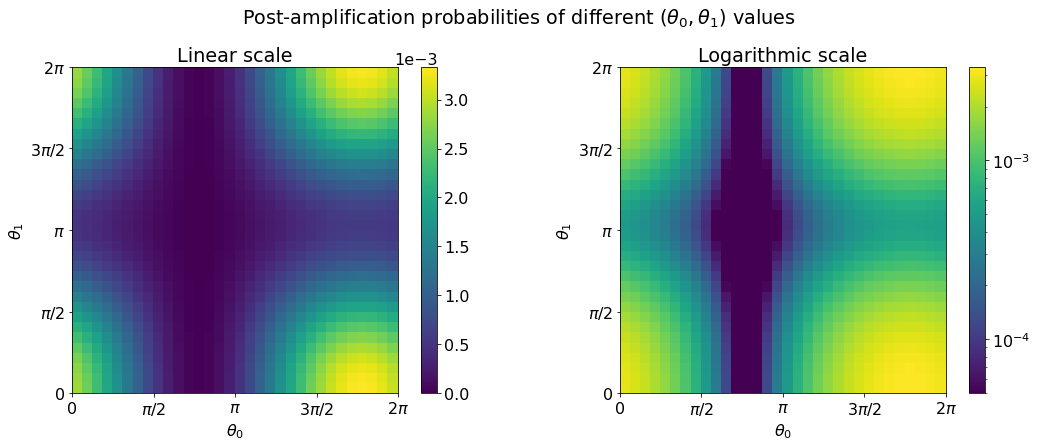

In [5]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(18, 6))

_ = ax0.pcolormesh(param_0_binedges, param_1_binedges, amplified_probs_grid)
cbar = plt.colorbar(_, ax=ax0)
cbar.formatter.set_powerlimits((0, 0))
ax0.set_aspect('equal')
ax0.set_title("Linear scale")

_ = ax1.pcolormesh(param_0_binedges, param_1_binedges, amplified_probs_grid, norm=LogNorm(vmin=5e-5))
plt.colorbar(_, ax=ax1)
ax1.set_aspect('equal')
ax1.set_title("Logarithmic scale")

for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta_{0}$')
    ax.set_ylabel(r'$\theta_{1}$')

fig.suptitle(r"Post-amplification probabilities of different $(\theta_{0}, \theta_{1})$ values", y=1.02)
None

#### Comparing the cost landscape with the post-amplification probabilities:

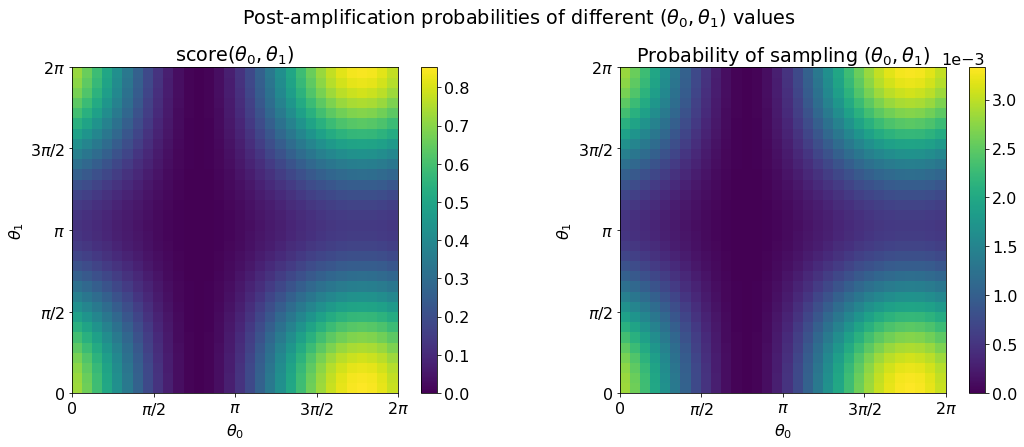

In [6]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(18, 6))

_ = ax0.pcolormesh(param_0_binedges, param_1_binedges, score_landscape)
plt.colorbar(_, ax=ax0)
ax0.set_aspect('equal')
ax0.set_title(r"$\mathrm{score}(\theta_0, \theta_1)$")

_ = ax1.pcolormesh(param_0_binedges, param_1_binedges, amplified_probs_grid)
cbar = plt.colorbar(_, ax=ax1)
cbar.formatter.set_powerlimits((0, 0))
ax1.set_aspect('equal')
ax1.set_title(r"Probability of sampling $(\theta_0, \theta_1)$")

for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta_{0}$')
    ax.set_ylabel(r'$\theta_{1}$')

fig.suptitle(r"Post-amplification probabilities of different $(\theta_{0}, \theta_{1})$ values", y=1.02)
None

## Discussion

* We can see from the plots above that the amplification process has increased the probabilities of the good values of $(\theta_0, \theta_1)$, i.e., parameter-values with higher scores.
* 


(5.497787143782138, 5.497787143782138)


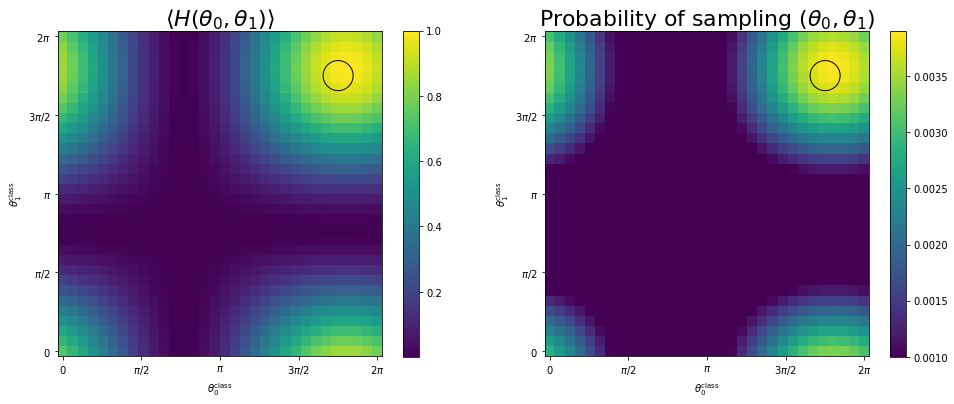

In [87]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import LogNorm

roundoff = 1e-3
score_landscape[score_landscape < roundoff] = roundoff
probabilities[probabilities < roundoff] = roundoff


fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(16, 6))

_ = ax0.pcolormesh(param_0_binedges, param_1_binedges, score_landscape)
# _ = ax0.pcolormesh(param_0_binedges, param_1_binedges, score_landscape, norm=LogNorm(vmin=1e-3))
plt.colorbar(_, ax=ax0)
ax0.set_aspect('equal')
ax0.set_title(r'$\langle H(\theta_0, \theta_1) \rangle$', size=22)

_ = ax1.pcolormesh(param_0_binedges, param_1_binedges, probabilities)
# _ = ax1.pcolormesh(param_0_binedges, param_1_binedges, probabilities, norm=LogNorm(vmin=1e-3))
plt.colorbar(_, ax=ax1)
ax1.set_aspect('equal')
ax1.set_title(r'Probability of sampling $(\theta_0, \theta_1)$', size=22)


# Circle overlay
center_idx = np.unravel_index(score_landscape.argmax(), score_landscape.shape)
center = (param_0_vals_flat[center_idx[0]], param_1_vals_flat[center_idx[1]])
print(center)
circ = plt.Circle(center, 0.3 , fill = False ) 
  
# axes.set_aspect( 1 ) 
ax1.add_artist( circ ) 
circ2 = plt.Circle(center, 0.3 , fill = False ) 

ax0.add_artist( circ2 ) 



for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta^\mathrm{class}_0$')
    ax.set_ylabel(r'$\theta^\mathrm{class}_1$')

# fig.suptitle(r"Score function for different $(\theta^\mathrm{class}_0, \theta^\mathrm{class}_1)$ values", y=1.02)
None

In [ ]:
def centered_arr_integrate(c, r):
    """Numerically integrate an array """

In [31]:
import matplotlib.pyplot as plt
import numpy as np

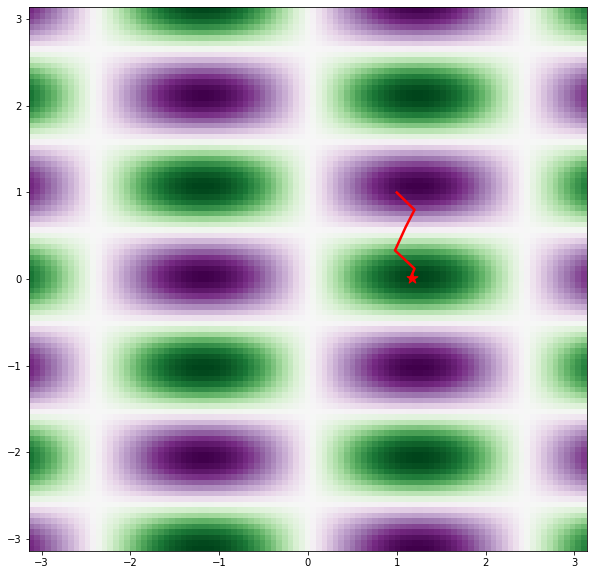

In [28]:
# Dummy cost fucntion; replace with something nice later
cost_func = lambda x, y: np.cos(3*x) * np.sin(1.3 * y)
algorithm_steps = np.asarray([(1, 1), (1.2, 0.8), (1.1, 0.6), (0.98, 0.33), (1.2, 0.12), (1.15, 0.00), (1.17, 0.01)])
steps_x, steps_y = zip(*algorithm_steps)
steps_x = np.asarray(steps_x)
steps_y = np.asarray(steps_y)

npts = 100
x = np.linspace(-np.pi, np.pi, npts)
y = np.linspace(-np.pi, np.pi, npts)
z = np.asarray([cost_func(xi, yj) for xi in x for yj in y])

X, Y = np.meshgrid(x, y)
Z = z.reshape(npts, npts)

cmap = 'PRGn'
stepscolor = 'r'
fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolor(X, Y, Z, cmap=cmap)
ax.plot(steps_x, steps_y, c=stepscolor, lw=2.5)
ax.scatter(steps_x[-1], steps_y[-1], marker="*", s=130, c=stepscolor)

### Discussion

Grover serach for quantum circuit optimization presents an exciting opportunity blah blah blah